In [1]:
import seaborn as sns

from motifs.pipeline import Pipeline
from motifs.plots import plot_motif_histogram, plot_tf_idf
from motifs.pca import pca_transform
from motifs.config import PKG_DATA_PATH

corpus_path = PKG_DATA_PATH.joinpath('corpus_test')
token_type = "motif"
feature = {"name": "tfidf"}
n = 4

# Create pipeline object and perform annotation

In [2]:
pipeline = Pipeline(token_type, feature, n, corpus_dir=corpus_path, save=False)

[PyMotifs-Logger:tokenizer.py:263] - [99693] - 2024-01-08 15:34:19 - DEBUG - Steps to go 3: tokenizing Huysmans-Rebours.txt...
[PyMotifs-Logger:tokenizer.py:278] - [99693] - 2024-01-08 15:34:21 - DEBUG - Done with Huysmans-Rebours.txt in 1.96 seconds.
[PyMotifs-Logger:tokenizer.py:263] - [99693] - 2024-01-08 15:34:21 - DEBUG - Steps to go 2: tokenizing Flaubert-Bovary.txt...
[PyMotifs-Logger:tokenizer.py:278] - [99693] - 2024-01-08 15:34:23 - DEBUG - Done with Flaubert-Bovary.txt in 2.05 seconds.
[PyMotifs-Logger:tokenizer.py:263] - [99693] - 2024-01-08 15:34:23 - DEBUG - Steps to go 1: tokenizing Balzac-Goriot.txt...
[PyMotifs-Logger:tokenizer.py:278] - [99693] - 2024-01-08 15:34:25 - DEBUG - Done with Balzac-Goriot.txt in 2.27 seconds.


# Transform tokens to n-grams and present simple statistics

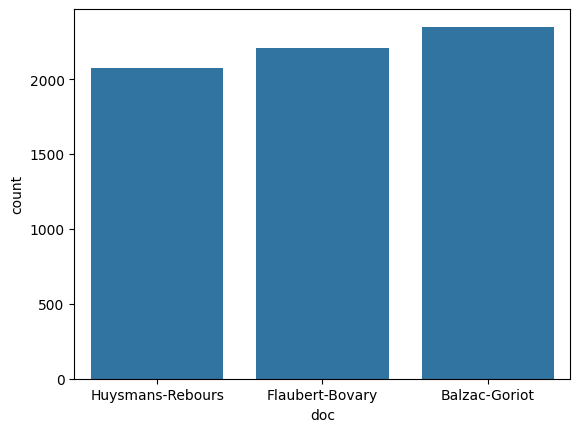

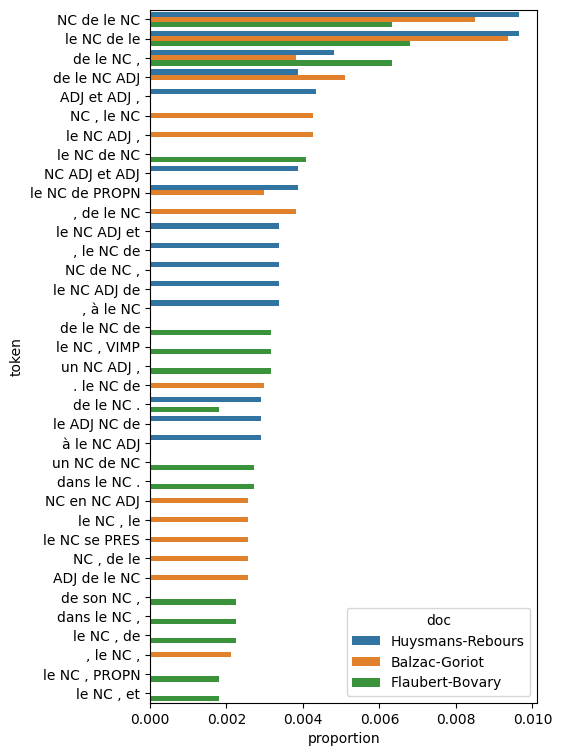

In [3]:
# Transform to n_grams
pipeline.transform_to_ngrams()
## Plot the count of tokens for each document within the corpus
sns.countplot(pipeline.ngrams, x="doc")
# Plot distribution of tokens
plot_motif_histogram(pipeline.ngrams, stat="proportion", n_tokens=15, plot_type="group")

# Compute features

In this example, we use tfidf features and we plot the most frequent ones

/Users/brunospilak/miniconda3/envs/pymotifs/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


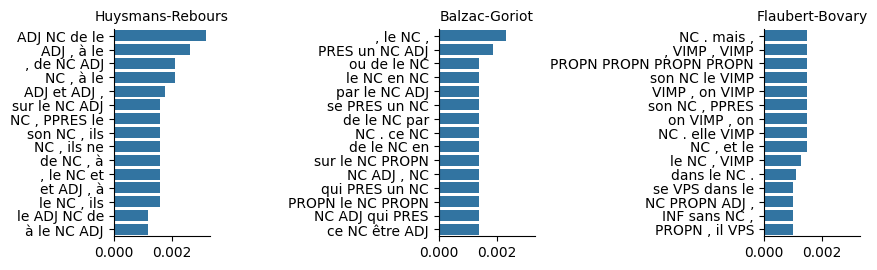

In [4]:
features_data = pipeline.get_features()
plot_tf_idf(features_data, n_tokens=15, plot_type="sep")

# Principal Component Analysis

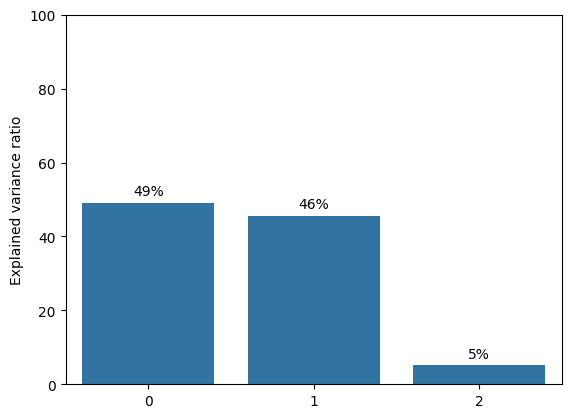

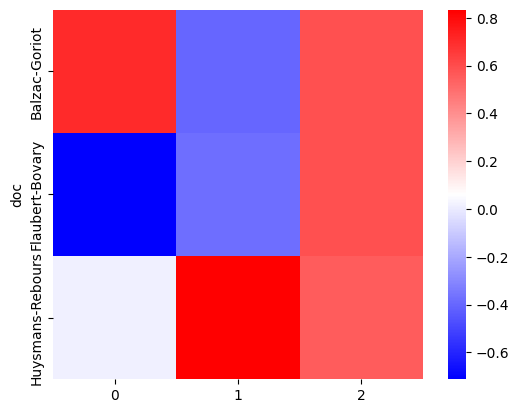

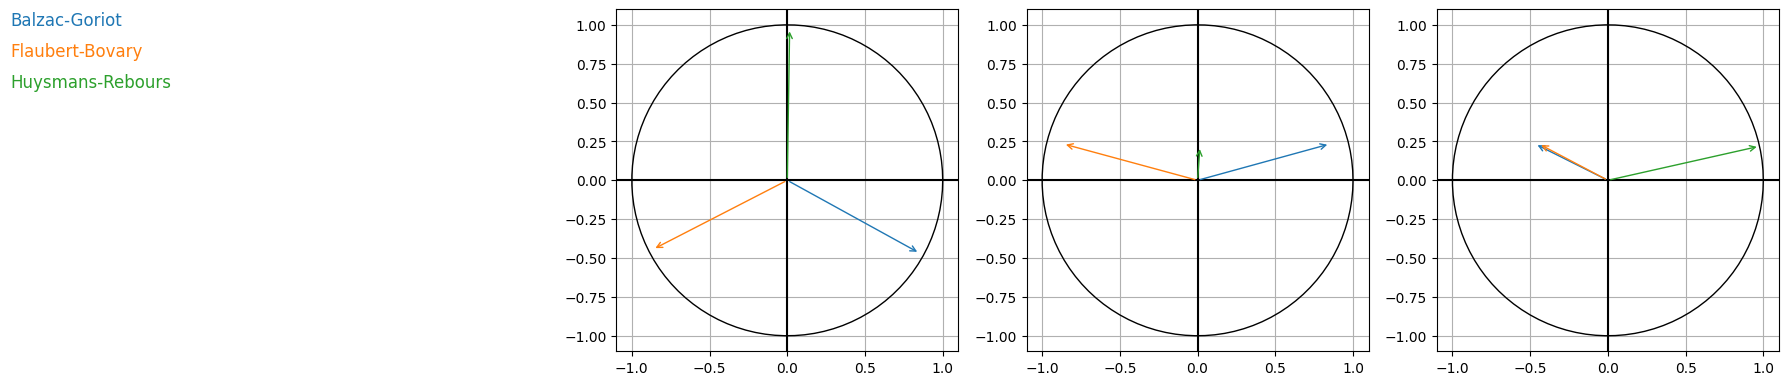

In [5]:
pca = pca_transform(
    features_data.pivot_table(
        index="token", columns=["doc"], values=feature["name"]
    ), 
    plot=True
)

# We can also execute the featurization and PCA in one call

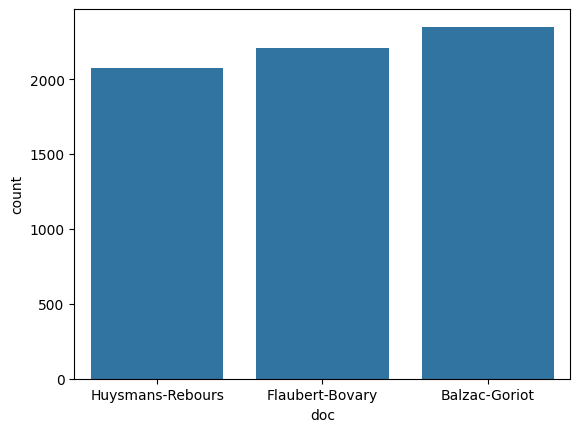

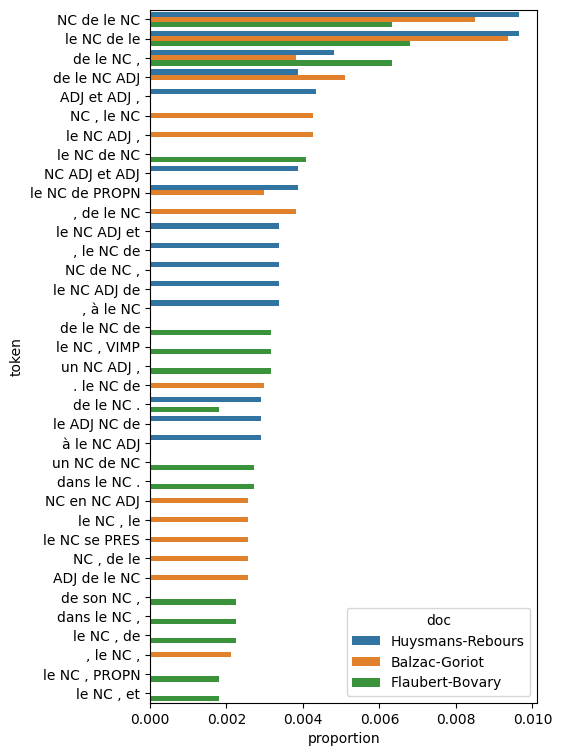

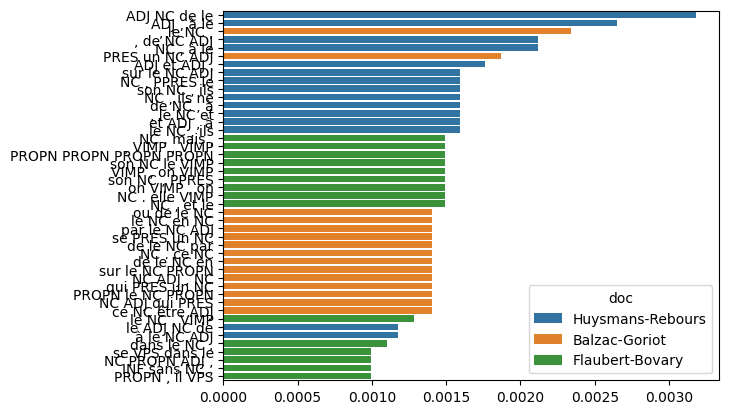

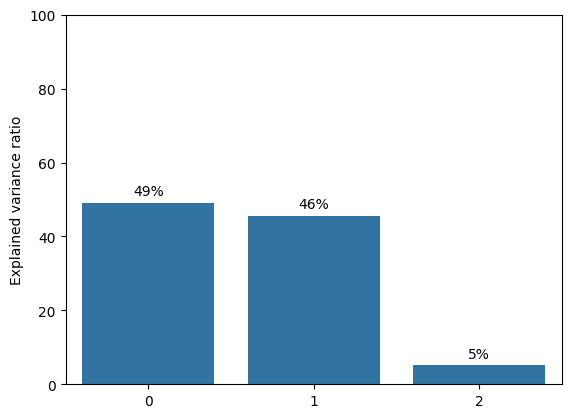

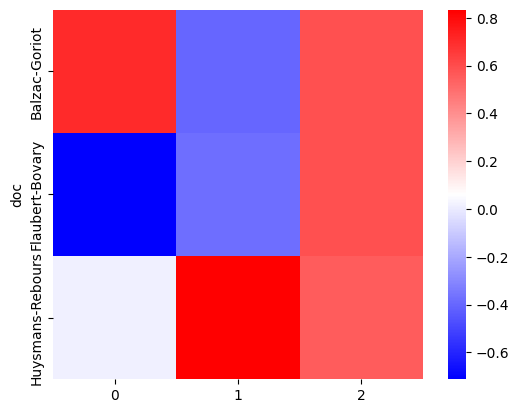

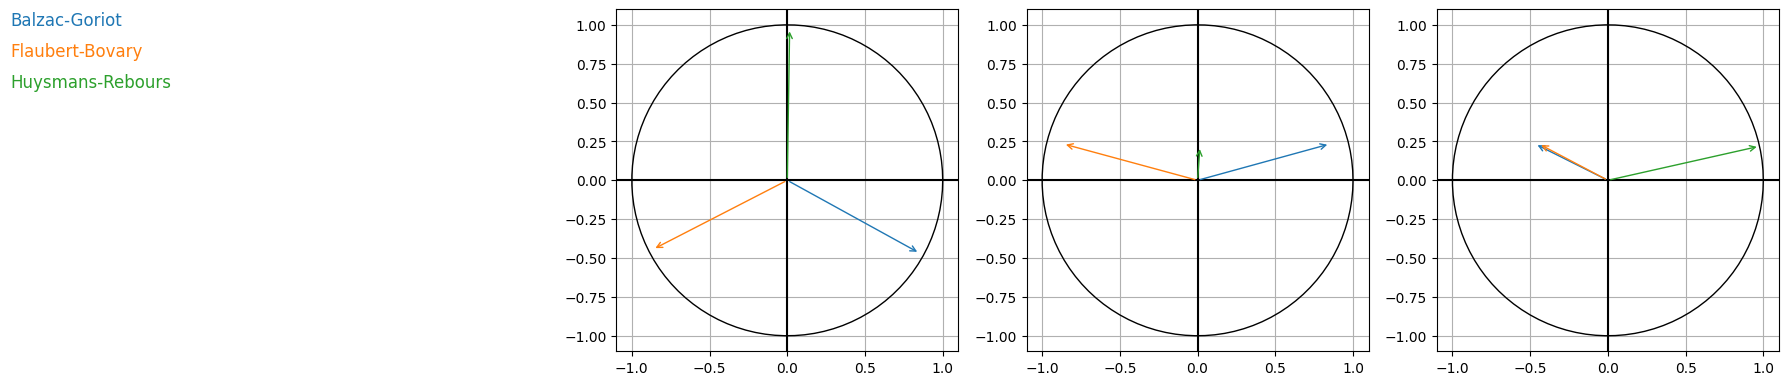

In [6]:
pipeline.execute("pca", plot=True, stat="proportion", n_tokens=15, plot_type="group")

# Specificity

In [7]:
from motifs.features import build_specificity
spec = build_specificity(pipeline.ngrams)

In [8]:
# Show the 10 most specific tokens for Balzac-Goriot:
doc = "Balzac-Goriot"
spec.sort_values(by=[doc, "spec"], ascending=False).head(10)

,Balzac-Goriot,Flaubert-Bovary,Huysmans-Rebours,doc,f,t,spec,rel_f
token,,,,,,,,
. le NC de,2.414691,0.000000,-1.302795,Balzac-Goriot,7,2350,2.414691,0.002979
. le NC de,2.414691,0.000000,-1.302795,Huysmans-Rebours,1,2073,-1.302795,0.000482
", le NC ,",2.254405,0.000000,0.000000,Balzac-Goriot,5,2350,2.254405,0.002128
NC en NC ADJ,2.017423,-1.232639,0.000000,Balzac-Goriot,6,2350,2.017423,0.002553
le NC se PRES,2.017423,-1.232639,0.000000,Balzac-Goriot,6,2350,2.017423,0.002553
NC en NC ADJ,2.017423,-1.232639,0.000000,Flaubert-Bovary,1,2210,-1.232639,0.000452
le NC se PRES,2.017423,-1.232639,0.000000,Flaubert-Bovary,1,2210,-1.232639,0.000452
PRES un NC ADJ,1.803285,0.000000,0.000000,Balzac-Goriot,4,2350,1.803285,0.001702
"ADJ , le NC",1.627963,0.000000,-0.976918,Balzac-Goriot,5,2350,1.627963,0.002128


It seems that in Goriot, Balzac often starts a sentence with "le NC de". This motif is highly specific to Balzac-Goriot with an index of 2.41 and appearing 7 times. It is under-represented in Huysmans-Rebours with a negative specificity of -1.3, appearing only once. It is not represented in Flaubert-Bovary.

# Top down analysis


We have identified a very specific motif ". le NC de" in Balzac-Goriot. Let us understand patterns in the original texts around this motif.

## Cooccurrence

First, it is important to check which motifs occur with the selected motif.

The analysis of cooccurrence is done at a context level. Thus we must transform the n-grams text into windows of n-grams of arbitrary length. For this, we use the `build_window_corpus`. For example, we can set the context length to 2 to check the immediate coocurrence (left and right).

Then we find the cooccurrent tokens with `from motifs.metrics import find_cooccurrent_token`.

In [11]:
# Transform to context data frame
from motifs.utils import build_window_corpus
from motifs.metrics import find_cooccurrent_tokens

token = ". le NC de"
windows = build_window_corpus(pipeline.ngrams, 3)

# Within a single text
tokens = find_cooccurrent_tokens(
    token, windows[windows.doc == doc], 10
)
tokens

,token,count
0,ADJ . le NC,1
1,NC . le NC,1
2,NC de chaque NC,1
3,NC de le NC,1
4,le NC de chaque,1
5,de NC . le,1
6,le NC de le,1
7,le NC de entre,1
8,le NC de ce,3
9,NC de ce NC,3


We can also check the cooccurrence of the motif at the corpus level without filtering, using `corpus_cooccurrent_tokens`

In [12]:
# At the corpus level
from motifs.metrics import corpus_cooccurrent_tokens
cooccurent_tokens = corpus_cooccurrent_tokens(token, windows, 10)
cooccurent_tokens

,token,count,doc
0,ADJ . le NC,1,Balzac-Goriot
1,NC . le NC,1,Balzac-Goriot
2,NC de chaque NC,1,Balzac-Goriot
3,NC de le NC,1,Balzac-Goriot
4,le NC de chaque,1,Balzac-Goriot
5,de NC . le,1,Balzac-Goriot
6,le NC de le,1,Balzac-Goriot
7,le NC de entre,1,Balzac-Goriot
8,le NC de ce,3,Balzac-Goriot
9,NC de ce NC,3,Balzac-Goriot


# <span style="color:red">ERROR: we have overlapping windows here, for cooccurence we should check non-overlapping n-grams right?</span>

## Return-to-text

It is worth looking into the original text to understand how the motif is used.

For this we use the `return_to_text_from_token` function with a context length of 5 tokens, as it follows:

In [13]:
from motifs.utils import return_to_text_from_token
context_len = 5
context = return_to_text_from_token(pipeline.ngrams, token, n, context_len)
context

,left_context,text,right_context,doc,token
0,"dans le sang , apparaissaient",. La décadence de,"cette ancienne maison avait ,",Huysmans-Rebours,. le NC de
1,? le doute est permis,. Les particularités de,cette scène pleine d' observations,Balzac-Goriot,. le NC de
2,un fruit savoureux promptement dévoré,. Le char de,"la civilisation , semblable à",Balzac-Goriot,. le NC de
3,voyez coupée dans sa profondeur,. Le long de,"cette façade , entre la",Balzac-Goriot,. le NC de
4,ses conversations avec les pensionnaires,. Le long de,"chaque muraille , règne une",Balzac-Goriot,. le NC de
5,leurs lignes jurent entre elles,. La profondeur de,cette maison comporte deux croisées,Balzac-Goriot,. le NC de
6,lambrissée à hauteur d' appui,. Le surplus de,les parois est tendu d',Balzac-Goriot,. le NC de
7,les classiques personnages sont coloriés,. Le panneau d',entre les croisées grillagées offre,Balzac-Goriot,. le NC de


# Bottom up analysis

## Cooccurrence

For example, we can find the top $n$ coocurrent motif within a single document like Balzac-Goriot with `find_top_n_cooccurrence`. We use $n=5$ in the example below:

In [14]:
# Within a single text
from motifs.metrics import find_top_n_cooccurrence
cooc = find_top_n_cooccurrence(windows[windows.doc == doc], 5)
cooc

,token1,token2,count
0,"NC , le NC","le NC , le",4
1,"NC ADJ , le","le NC ADJ ,",4
2,", de le NC","NC , de le",4
3,de le NC ADJ,"le NC ADJ ,",5
4,NC de le NC,le NC de le,13


# <span style="color:red">ERROR: we have overlapping windows here, for cooccurence we should check non-overlapping n-grams right?</span>

## Specificity

For example, we can check the original text for the most specific tokens in the corpus with the function `return_to_text_from_spec`. To only return a reasonable number of tokens, we apply a filter on the tokens. We return the tokens that have a minimum specificity of 1 (`min_spec=1`) and a minimum frequency of 2 (`min_freq=2`, default behavior).

In [15]:
from motifs.utils import return_to_text_from_spec
import time
t1 = time.time()
context = return_to_text_from_spec(pipeline.ngrams, spec, n, context_len, min_spec=1, min_freq=2)
t2 = time.time()
print(t2-t1)
context

0.267852783203125


,left_context,text,right_context,doc,spec,f,t
token,,,,,,,
"ADJ et ADJ ,","le présent , une tête","mystérieuse et rusée ,",à les traits morts et,Huysmans-Rebours,3.694120,9,2073
"ADJ et ADJ ,","rusée , à les traits","morts et tirés ,",à les pommettes ponctuées d',Huysmans-Rebours,3.694120,9,2073
"ADJ et ADJ ,","homme de trente ans ,","anémique et nerveux ,","à les joues caves ,",Huysmans-Rebours,3.694120,9,2073
"ADJ et ADJ ,",", une longue femme ,","silencieuse et blanche ,",mourut d' épuisement ; à,Huysmans-Rebours,3.694120,9,2073
"ADJ et ADJ ,","il se la rappelait ,","immobile et couchée ,",dans une chambre obscure de,Huysmans-Rebours,3.694120,9,2073
...,...,...,...,...,...,...,...
le NC ADJ et,"les tourbières , jusqu' à",le hameau vert et,"noir de Longueville , ou",Huysmans-Rebours,-2.290466,1,2210
le NC ADJ et,se révélaient ainsi que de,les êtres immuables et,"nuls ; là , les",Huysmans-Rebours,-2.290466,1,2210
le NC ADJ et,"communiaient à Pâques , hantaient",les cercles catholiques et,ils se cachaient ainsi que,Huysmans-Rebours,-2.290466,1,2210
